### Librerias Usadas.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD, PCA
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models import Word2Vec
from scipy.sparse import csr_matrix, hstack
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import tensorflow as tf
import re, string, nltk
# Descarga de recursos
nltk.download('wordnet')
nltk.download('punkt')
tf.test.gpu_device_name()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'/device:GPU:0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Lectura de los datos

In [4]:
dataFake = pd.read_csv("/content/drive/MyDrive/Fake.csv")
dataFake["class"] = 0
print("Fake: ",dataFake.shape)

dataTrue = pd.read_csv("/content/drive/MyDrive/True.csv")
dataTrue["class"] = 1
print("True: ",dataTrue.shape)

data_merge = pd.concat([dataFake,dataTrue], axis=0)
data = data_merge.drop(["title","subject","date"], axis=1)
print("All data: ",data.shape)

Fake:  (23481, 5)
True:  (21417, 5)
All data:  (44898, 2)


## Limpieza

In [5]:
'''
  Función que elimina los símbolos especiales de un texto,
  así como las stopwords
'''
def word_cleaner(text):
  text = text.lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('\\W', ' ', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return remove_stopwords(text)

'''
  Función que dado un texto, lo limpia y elimina las letras aisladas existentes.
'''
def text_cleaner(text, lemmatizer):
  text = word_cleaner(text)
  tokens = word_tokenize(text)
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
  text = remove_letters(lemmatized_tokens)
  text = " ".join(text)
  return text

'''
  Funcion que elimina las palabras con lengitud menor a length
'''
def remove_letters(lemas, length=2):
  return [word for word in lemas if len(word)>length]

'''
  Funcion que cuenta la frecuencia de palabras en el dataset
'''
def count_tokens(texts, wf):
  for text in texts:
    tokens = text.split()
    wf.update(tokens)
  return wf

'''
  Funcion que dado el dataset y la lista de palabras que no tienen una 
  frecuencua valida las elimina del dataset
'''
def remove_max_min_words_freq(texts, words_to_remove):
  filtered_texts = []
  for text in texts:
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in words_to_remove]
    filtered_text = ' '.join(filtered_tokens)
    filtered_texts.append(filtered_text)
  return filtered_texts

'''
  Funcion que obtiene la lista de palabras a eliminar
'''
def get_words_to_remove(min_freq =2, max_freq=1000, word_freq=None):
  return [word for word, freq in word_freq.items() if freq < min_freq or freq > max_freq]

### Aplicación de limpieza a datos



In [6]:
clean_data = data.copy()

In [7]:
lemmatizer = WordNetLemmatizer()
clean_data["text"] = clean_data['text'].apply(text_cleaner, args=(lemmatizer,))

In [8]:
clean_data['text']

0        donald trump couldn wish american happy new ye...
1        house intelligence committee chairman devin nu...
2        friday revealed milwaukee sheriff david clarke...
3        christmas day donald trump announced work foll...
4        pope francis annual christmas day message rebu...
                               ...                        
21412    brussels reuters nato ally tuesday welcomed pr...
21413    london reuters lexisnexis provider legal regul...
21414    minsk reuters shadow disused soviet era factor...
21415    moscow reuters vatican secretary state cardina...
21416    jakarta reuters indonesia buy sukhoi fighter j...
Name: text, Length: 44898, dtype: object

### Solo es requerido ejecutar esta celsa si se desea probar la eliminación de palabras con frecuencia max y min.


In [ ]:
# Importacion de recursos
#from collections import Counter
# Instancias 
#word_freq = Counter()

In [ ]:
# head = clean_data.head(100)
# tail = clean_data.tail(100)
# clean_data = pd.concat([head,tail])
# word_freq = count_tokens(clean_data['text'], word_freq)
# words = get_words_to_remove(5,1000,word_freq)
# clean_data["text"] = remove_max_min_words_freq(clean_data["text"] ,words)

## Separación de datos de entrenamiento y de prueba

In [9]:
SEED = 123456789

x = clean_data['text']
y = clean_data['class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=SEED)

print(f"Datos de entrenamiento: {len(x_train)} ({len(x_train)/len(x):%})")
print(f"Datos de prueba: \t{len(x_test)} ({len(x_test)/len(x):%})")

Datos de entrenamiento: 33673 (74.998886%)
Datos de prueba: 	11225 (25.001114%)


## Preprocesamiento

### Vectorización TFID:

In [10]:
tfid_vectorizer = TfidfVectorizer()
x_tfid_train = tfid_vectorizer.fit_transform(x_train)
x_tfid_test = tfid_vectorizer.transform(x_test)

### Vectorización por frecuencia

In [11]:
count_vectorizer = CountVectorizer()
x_count_train = count_vectorizer.fit_transform(x_train)
x_count_test = count_vectorizer.transform(x_test)

### Vectorización por Word2Vec


In [12]:
# Vectorización con Word2Vec
def vectorize_W2V(x_train, x_test):
  # Concatenar series2 al frente de series1
  X = pd.concat([x_train, x_test], axis=0)
  sentences = [text.split() for text in X]
  word2vec_model = Word2Vec(sentences, min_count=1)
  # Obtener el tamaño de los vectores de Word2Vec
  embedding_size = word2vec_model.vector_size
  # Obtener el promedio de los vectores de Word2Vec para cada texto
  X_word2vec = np.zeros((len(sentences), embedding_size))
  for i, text in enumerate(sentences):
      count = 0
      for word in text:
          if word in word2vec_model.wv:
              X_word2vec[i] += word2vec_model.wv[word]
              count += 1
      if count > 0:
          X_word2vec[i] /= count
  return X_word2vec

## Reducción de dimensiones con SVD

Dado que KNN es un algoritmo ineficiente para vectores grandes, se generan versiones reducidas en dimensión para cada vectorización.

In [ ]:
N_COMPONENTS = 800 # Arbitrario

In [ ]:
svd_tfid = TruncatedSVD(n_components=N_COMPONENTS)
x_tfid_train_svd = svd_tfid.fit_transform(x_tfid_train)
x_tfid_test_svd = svd_tfid.transform(x_tfid_test)
print(f"Varianza preservada: {svd_tfid.explained_variance_ratio_.sum()}")

Varianza preservada: 0.42790336467813783


In [ ]:
svd_count = TruncatedSVD(n_components=N_COMPONENTS)
x_count_train_svd = svd_count.fit_transform(x_count_train)
x_count_test_svd = svd_count.transform(x_count_test)
print(f"Varianza preservada: {svd_count.explained_variance_ratio_.sum()}")

Varianza preservada: 0.7299464587781508


## Ajuste de modelos

### Regresión logística sin SVD

Se ajusta un modelo de regresión logística a los vectores generados por TFID.

In [ ]:
LR_tfid = LogisticRegression(max_iter=1000)
LR_tfid.fit(x_tfid_train, y_train)
print(f"El algoritmo convergió después de {LR_tfid.n_iter_} iteraciones")

El algoritmo convergió después de [48] iteraciones


Se ajusta un modelo de regresión logística a los vectores generados por frecuencias de palabras.

In [ ]:
LR_count = LogisticRegression(max_iter=2000)
LR_count.fit(x_count_train, y_train)
print(f"El algoritmo convergió después de {LR_count.n_iter_} iteraciones")

El algoritmo convergió después de [132] iteraciones


### Regresión Logísitca con SVD

Se ajusta un modelo de regresión logística a los vectores generados por TFID y procesados por SVD.

In [ ]:
LR_tfid_svd = LogisticRegression(max_iter=1000)
LR_tfid_svd.fit(x_tfid_train_svd, y_train)
print(f"El algoritmo convergió después de {LR_tfid_svd.n_iter_} iteraciones")

El algoritmo convergió después de [33] iteraciones


Se ajusta un modelo de regresión logística a los vectores generados por frecuencias de palabras y procesados por SVD.

In [ ]:
LR_count_svd = LogisticRegression(max_iter=2000)
LR_count_svd.fit(x_count_train_svd, y_train)
print(f"El algoritmo convergió después de {LR_count_svd.n_iter_} iteraciones")

El algoritmo convergió después de [193] iteraciones


### K Nearest Neighbors con SVD

Se obtiene un valor de $K$ sensato para los modelos.

In [ ]:
K = 50 # Arbitrario
N_JOBS = 4

Se ajusta un modelo KNN a los vectores generados por TFID.

In [ ]:
KNN_tfid_svd = KNeighborsClassifier(n_neighbors=K, n_jobs=N_JOBS)
KNN_tfid_svd.fit(x_tfid_train_svd, y_train)

KNeighborsClassifier(n_jobs=4, n_neighbors=50)

Se ajusta un modelo KNN a los vectores generados por frecuencias de palabras.

In [ ]:
KNN_count_svd = KNeighborsClassifier(n_neighbors=K, n_jobs=N_JOBS)
KNN_count_svd.fit(x_count_train_svd, y_train)

KNeighborsClassifier(n_jobs=4, n_neighbors=50)

### Evaluación de los modelos

In [ ]:
class TrainedModel:
    def __init__(self, model, name, x_test, y_test) -> None:
        self.model = model
        self.name = name
        self.x_test = x_test
        self.y_test = y_test
        self.predict = model.predict(x_test)

In [ ]:
LR_tfid_tm = TrainedModel(LR_tfid, "LR + TFID", x_tfid_test, y_test)

In [ ]:
LR_count_tm = TrainedModel(LR_count, "LR + Count", x_count_test, y_test)

In [ ]:
LR_tfid_svd_tm = TrainedModel(LR_tfid_svd, f"LR + TFID + SVD ({N_COMPONENTS})", x_tfid_test_svd, y_test)

In [ ]:
LR_count_svd_tm = TrainedModel(LR_count_svd, f"LR + Count + SVD ({N_COMPONENTS})", x_count_test_svd, y_test)

In [ ]:
KNN_tfid_svd_tm = TrainedModel(KNN_tfid_svd, f"KNN ({KNN_tfid_svd.n_neighbors}) + TFID + SVD ({N_COMPONENTS})", x_tfid_test_svd, y_test)

In [ ]:
KNN_count_svd_tm = TrainedModel(KNN_count_svd, f"KNN ({KNN_count_svd.n_neighbors}) + Count + SVD ({N_COMPONENTS})", x_count_test_svd, y_test)

In [ ]:
trained_models = [
    LR_tfid_tm, LR_count_tm, LR_tfid_svd_tm, LR_count_svd_tm, KNN_tfid_svd_tm, KNN_count_svd_tm
]
labels = [0, 1]
target_names = ["Fake", "True"]

### Reportes de clasificación

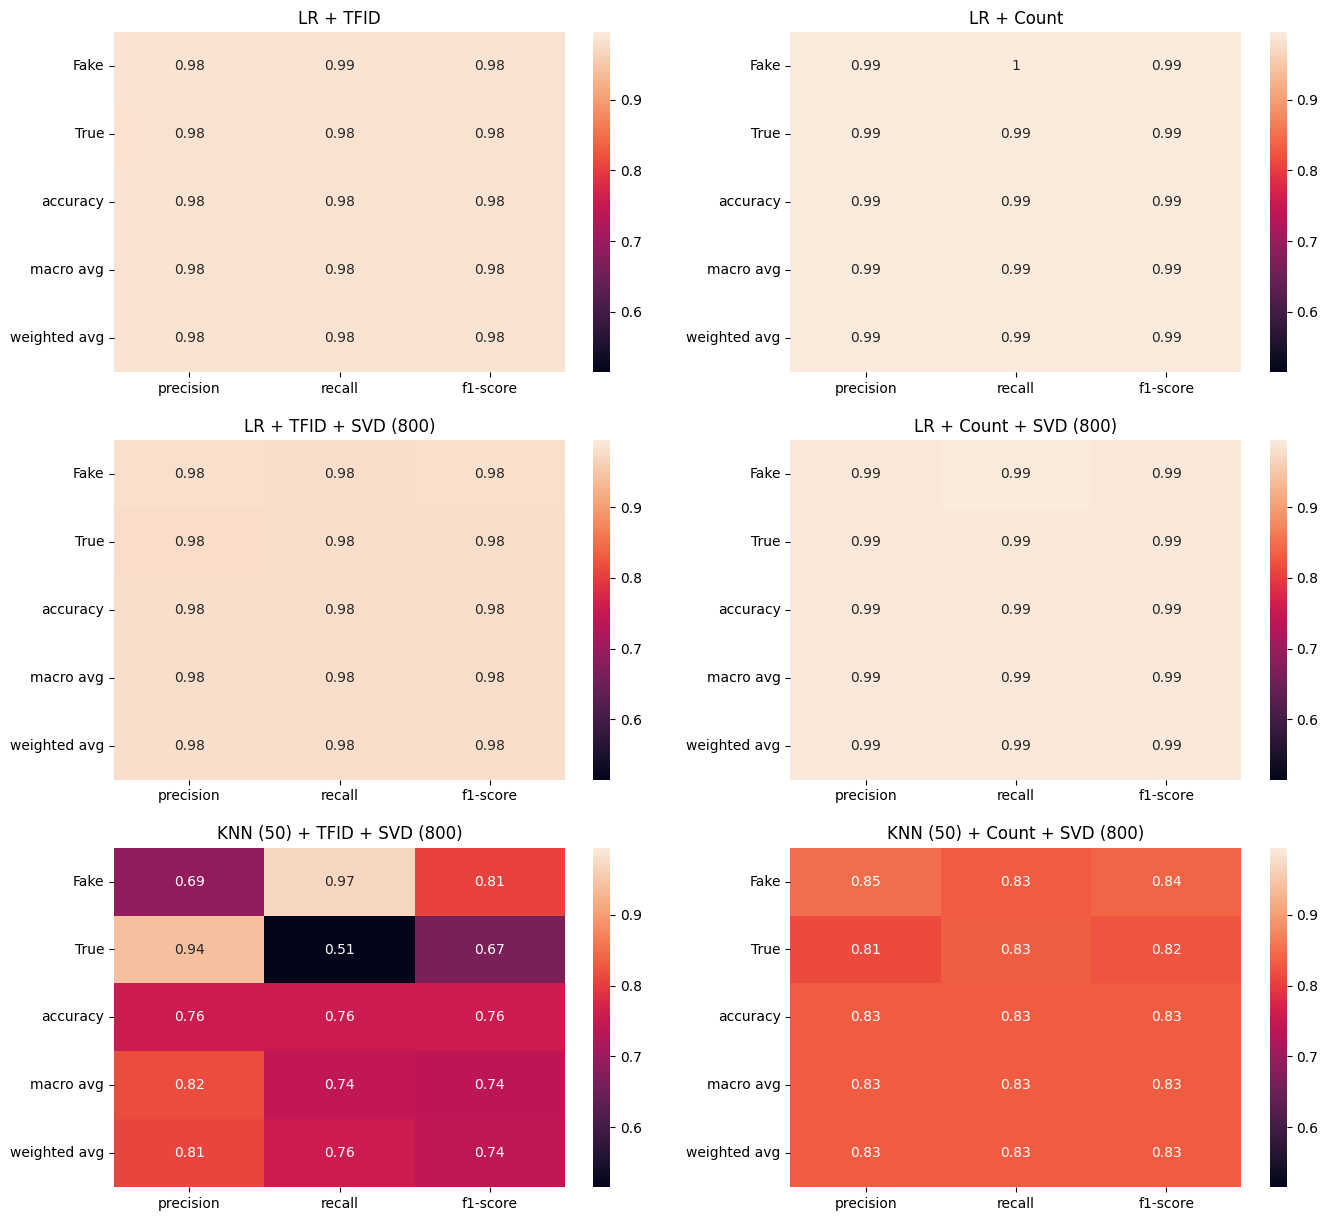

In [ ]:
def plot_clasification_reports(trained_models, labels, target_names, cols=2):
    # Se generan los reportes
    reports = [
        pd.DataFrame(
            classification_report(
                m.y_test,
                m.predict,
                labels=labels,
                target_names=target_names,
                output_dict=True,
            )
        )
        for m in trained_models
    ]

    # Se obtiene la norma de colores de todos los modelos
    # https://stackoverflow.com/a/70517313/15217078
    values = np.hstack([d.iloc[:-1, :].values.ravel() for d in reports])
    norm = mcolors.Normalize(values.min(), values.max())

    # Se generan las gráficas de los reportes
    # # https://stackoverflow.com/a/58948133/15217078
    rows = int(np.ceil(len(trained_models) / cols))
    fig, axes = plt.subplots(rows, cols)
    fig.set_size_inches(8 * cols, 5 * rows)
    for i, m in enumerate(trained_models):
        ax = axes[i // cols][i % cols]
        r = reports[i]
        sns.heatmap(r.iloc[:-1, :].T, annot=True, norm=norm, ax=ax)
        ax.set_title(m.name)
    return fig, axes


report_fig, report_axes = plot_clasification_reports(
    trained_models, labels, target_names
)


### Composición de vectorizaciones (Word2Vec y CountVectorizer)

In [13]:
# Obtenemos la vectorización de los conjuntos por medio de Count
cv = CountVectorizer()
x_count_train = cv.fit_transform(x_train)
x_count_test = cv.transform(x_test)

In [14]:
# Vectorización con Word2Vec
X_word2vec = vectorize_W2V(x_train, x_test)

In [15]:
X_word2vec

array([[-0.32941796, -0.03656066, -0.12243222, ..., -0.00519098,
        -0.0354011 , -0.47422846],
       [-0.22643775,  0.24648694,  0.27573859, ..., -0.39023075,
         0.06102473, -0.91011286],
       [ 0.27955749, -0.19588143,  0.36826082, ..., -0.79683853,
        -0.19747644, -0.77407814],
       ...,
       [-0.34883992,  0.84500782, -0.33878209, ...,  0.45278363,
         0.11879084, -0.4736971 ],
       [-0.46281012,  0.27416801,  0.59920353, ..., -0.83177671,
        -0.40328739, -0.4596751 ],
       [-0.54609463,  0.09582735, -0.00360175, ...,  0.39379976,
        -0.30379968,  0.04525596]])

In [16]:
# Obtenemos los conjutos ya vectorizados
X_word2vec_train = X_word2vec[:len(x_train)]
X_word2vec_test = X_word2vec[len(x_train):]

In [18]:
X_word2vec_train
X_word2vec_test

array([[-0.45088199, -0.05673292,  0.32818409, ..., -0.11405727,
         0.21056458,  0.04926554],
       [ 0.36916336, -0.1441179 ,  0.09549178, ...,  0.03681687,
        -0.24258389, -0.37457569],
       [-0.08997652,  0.76800573, -0.63023041, ...,  0.08295688,
        -0.09839158, -0.11288085],
       ...,
       [-0.34883992,  0.84500782, -0.33878209, ...,  0.45278363,
         0.11879084, -0.4736971 ],
       [-0.46281012,  0.27416801,  0.59920353, ..., -0.83177671,
        -0.40328739, -0.4596751 ],
       [-0.54609463,  0.09582735, -0.00360175, ...,  0.39379976,
        -0.30379968,  0.04525596]])

In [19]:
# Concatenamos las matrices dispersas y los arreglos a lo largo del eje de las columnas
X_concatenated_train = hstack([x_count_train, X_word2vec_train])
X_concatenated_test = hstack([x_count_test, X_word2vec_test])

In [21]:
X_concatenated_train
X_concatenated_test

<11225x86662 sparse matrix of type '<class 'numpy.float64'>'
	with 2679286 stored elements in COOrdinate format>

In [ ]:
# Entrenar el modelo de regresión logística
logreg = LogisticRegression(max_iter=2000)
logreg.fit(X_concatenated_train, y_train)
print(f"El algoritmo convergió después de {logreg.n_iter_} iteraciones")

El algoritmo convergió después de [141] iteraciones


In [ ]:
# Predecir las etiquetas para los datos de prueba
y_pred = logreg.predict(X_concatenated_test)

In [ ]:
# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.9951002227171493


In [ ]:
# Reducción de dimensionalidad para X_count
N_COMPONENTS = 100
svd_composition = TruncatedSVD(n_components=N_COMPONENTS)
x_comp_train_svd = svd_composition.fit_transform(x_count_train)
x_comp_test_svd = svd_composition.transform(x_count_test)

In [ ]:
# Concatenamos las matrices dispersas y los arreglos a lo largo del eje de las columnas
X_concatenated_train_svd= np.concatenate((x_comp_train_svd, X_word2vec_train), axis=1)
X_concatenated_test_svd= np.concatenate((x_comp_test_svd, X_word2vec_test), axis=1)

In [ ]:
# Entrenar el modelo de regresión logística
logreg_svd = LogisticRegression(max_iter=2000)
logreg_svd.fit(X_concatenated_train_svd, y_train)
print(f"El algoritmo convergió después de {logreg_svd.n_iter_} iteraciones")

El algoritmo convergió después de [314] iteraciones


In [ ]:
# Predecir las etiquetas para los datos de prueba
y_pred = logreg_svd.predict(X_concatenated_test_svd)

In [ ]:
# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo (SVD sobre Count a {N_COMPONENTS}):", accuracy)

Precisión del modelo (SVD sobre Count a 100): 0.9795100222717149


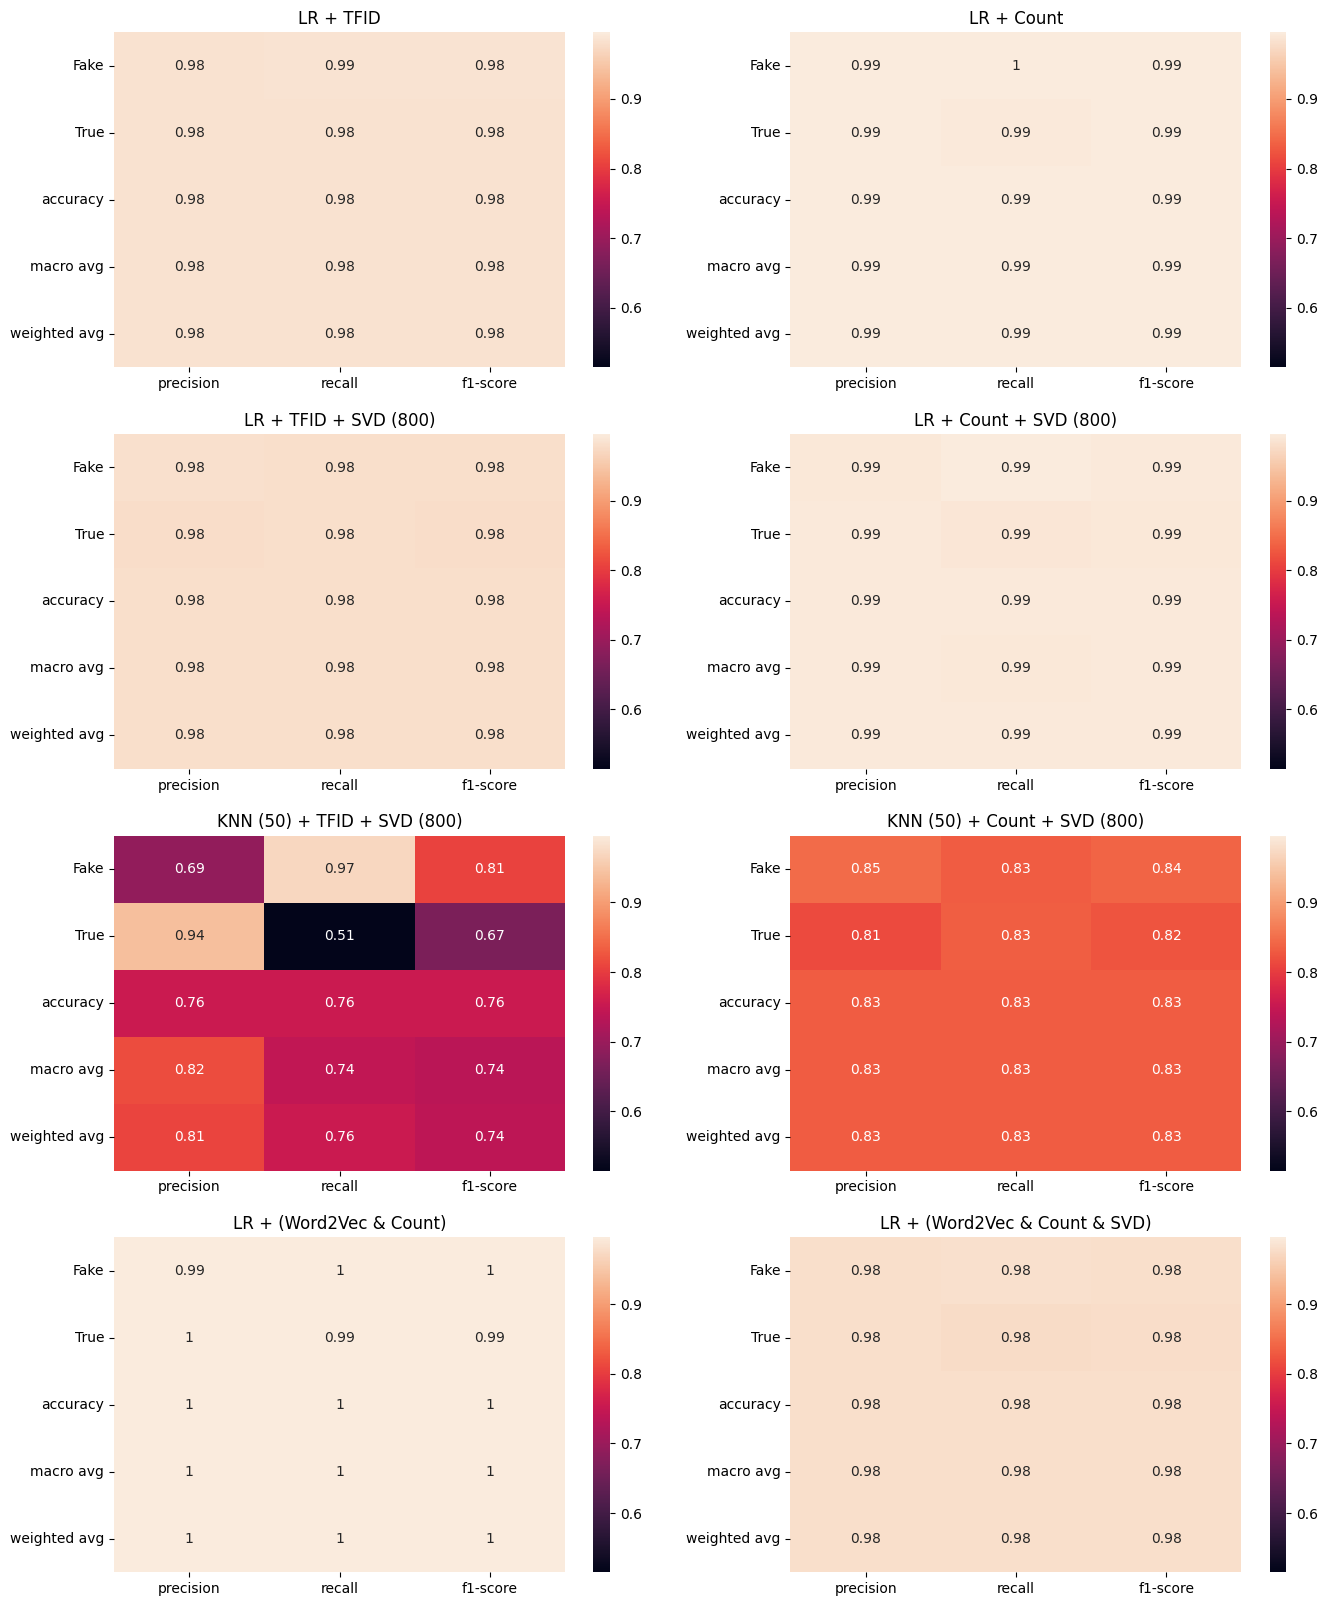

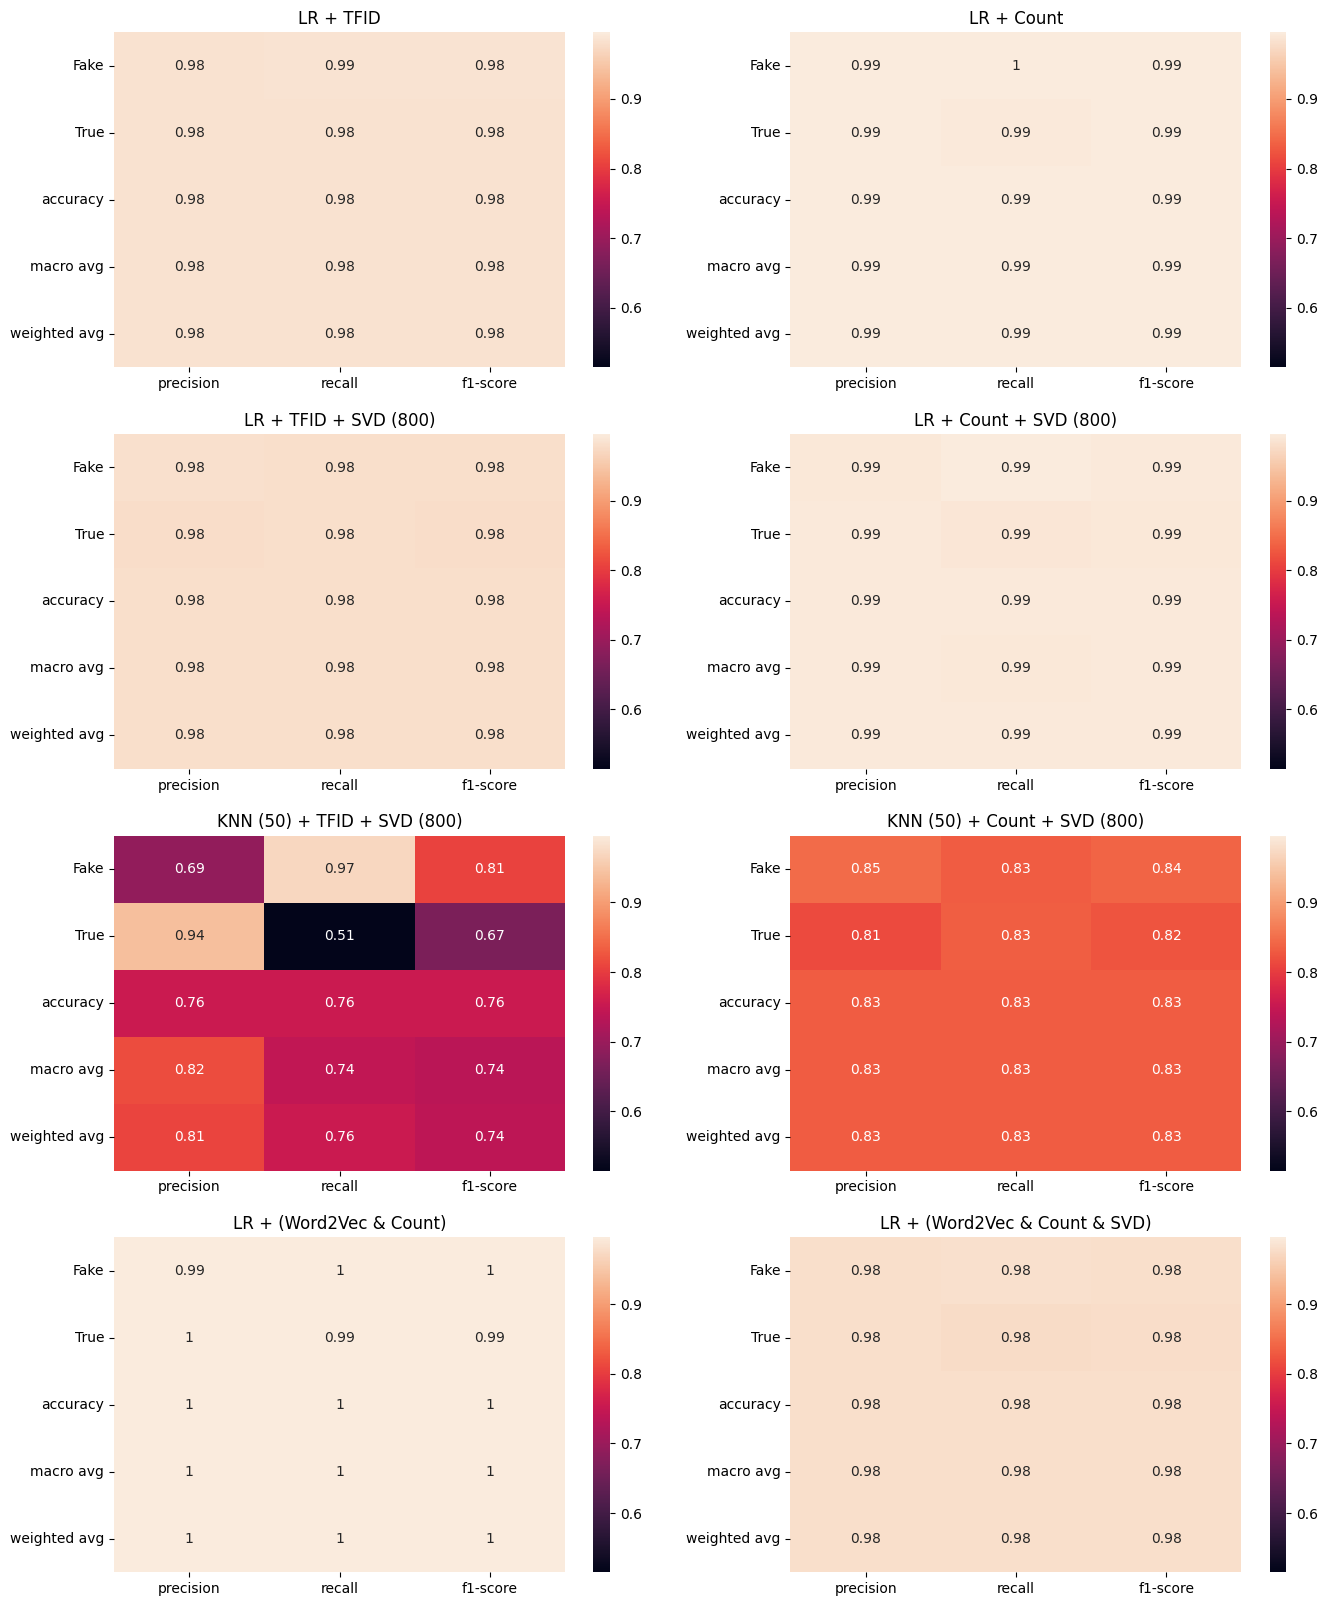

In [ ]:
# Creamos los modelos creados anteriormente
LR_Word_Count = TrainedModel(logreg, "LR + (Word2Vec & Count)", X_concatenated_test, y_test)
LR_Word_Count_SVD = TrainedModel(logreg_svd, "LR + (Word2Vec & Count & SVD)", X_concatenated_test_svd, y_test)
# Los añadimos a la lista de modelos entrenados
trained_models.append(LR_Word_Count)
trained_models.append(LR_Word_Count_SVD)

report_fig, report_axes = plot_clasification_reports(
    trained_models, labels, target_names
)
report_fig, report_axes = plot_clasification_reports(trained_models, labels, target_names)

### Se prueban diferentes valores para K

In [ ]:
K_values = [
    75,
    100,
    150,
    200,
    225,
    250,
    300,
    350,
    400,
    500,
    600,
    700
]

#### Primero probamos con TFID

In [ ]:
KNN_TFID_models = []
N_COMPONENTS = 800

for k in K_values:
    model = KNeighborsClassifier(n_neighbors=k, n_jobs=N_JOBS)
    model.fit(x_tfid_train_svd, y_train)
    KNN_TFID_models.append(model)
    

In [ ]:
trained_KNN_TDIF_models = []
for model in KNN_TFID_models:
    trained_model = TrainedModel(model, f"KNN ({model.n_neighbors}) + TFID + SVD ({N_COMPONENTS})", x_count_test_svd, y_test)
    trained_KNN_TDIF_models.append(trained_model)

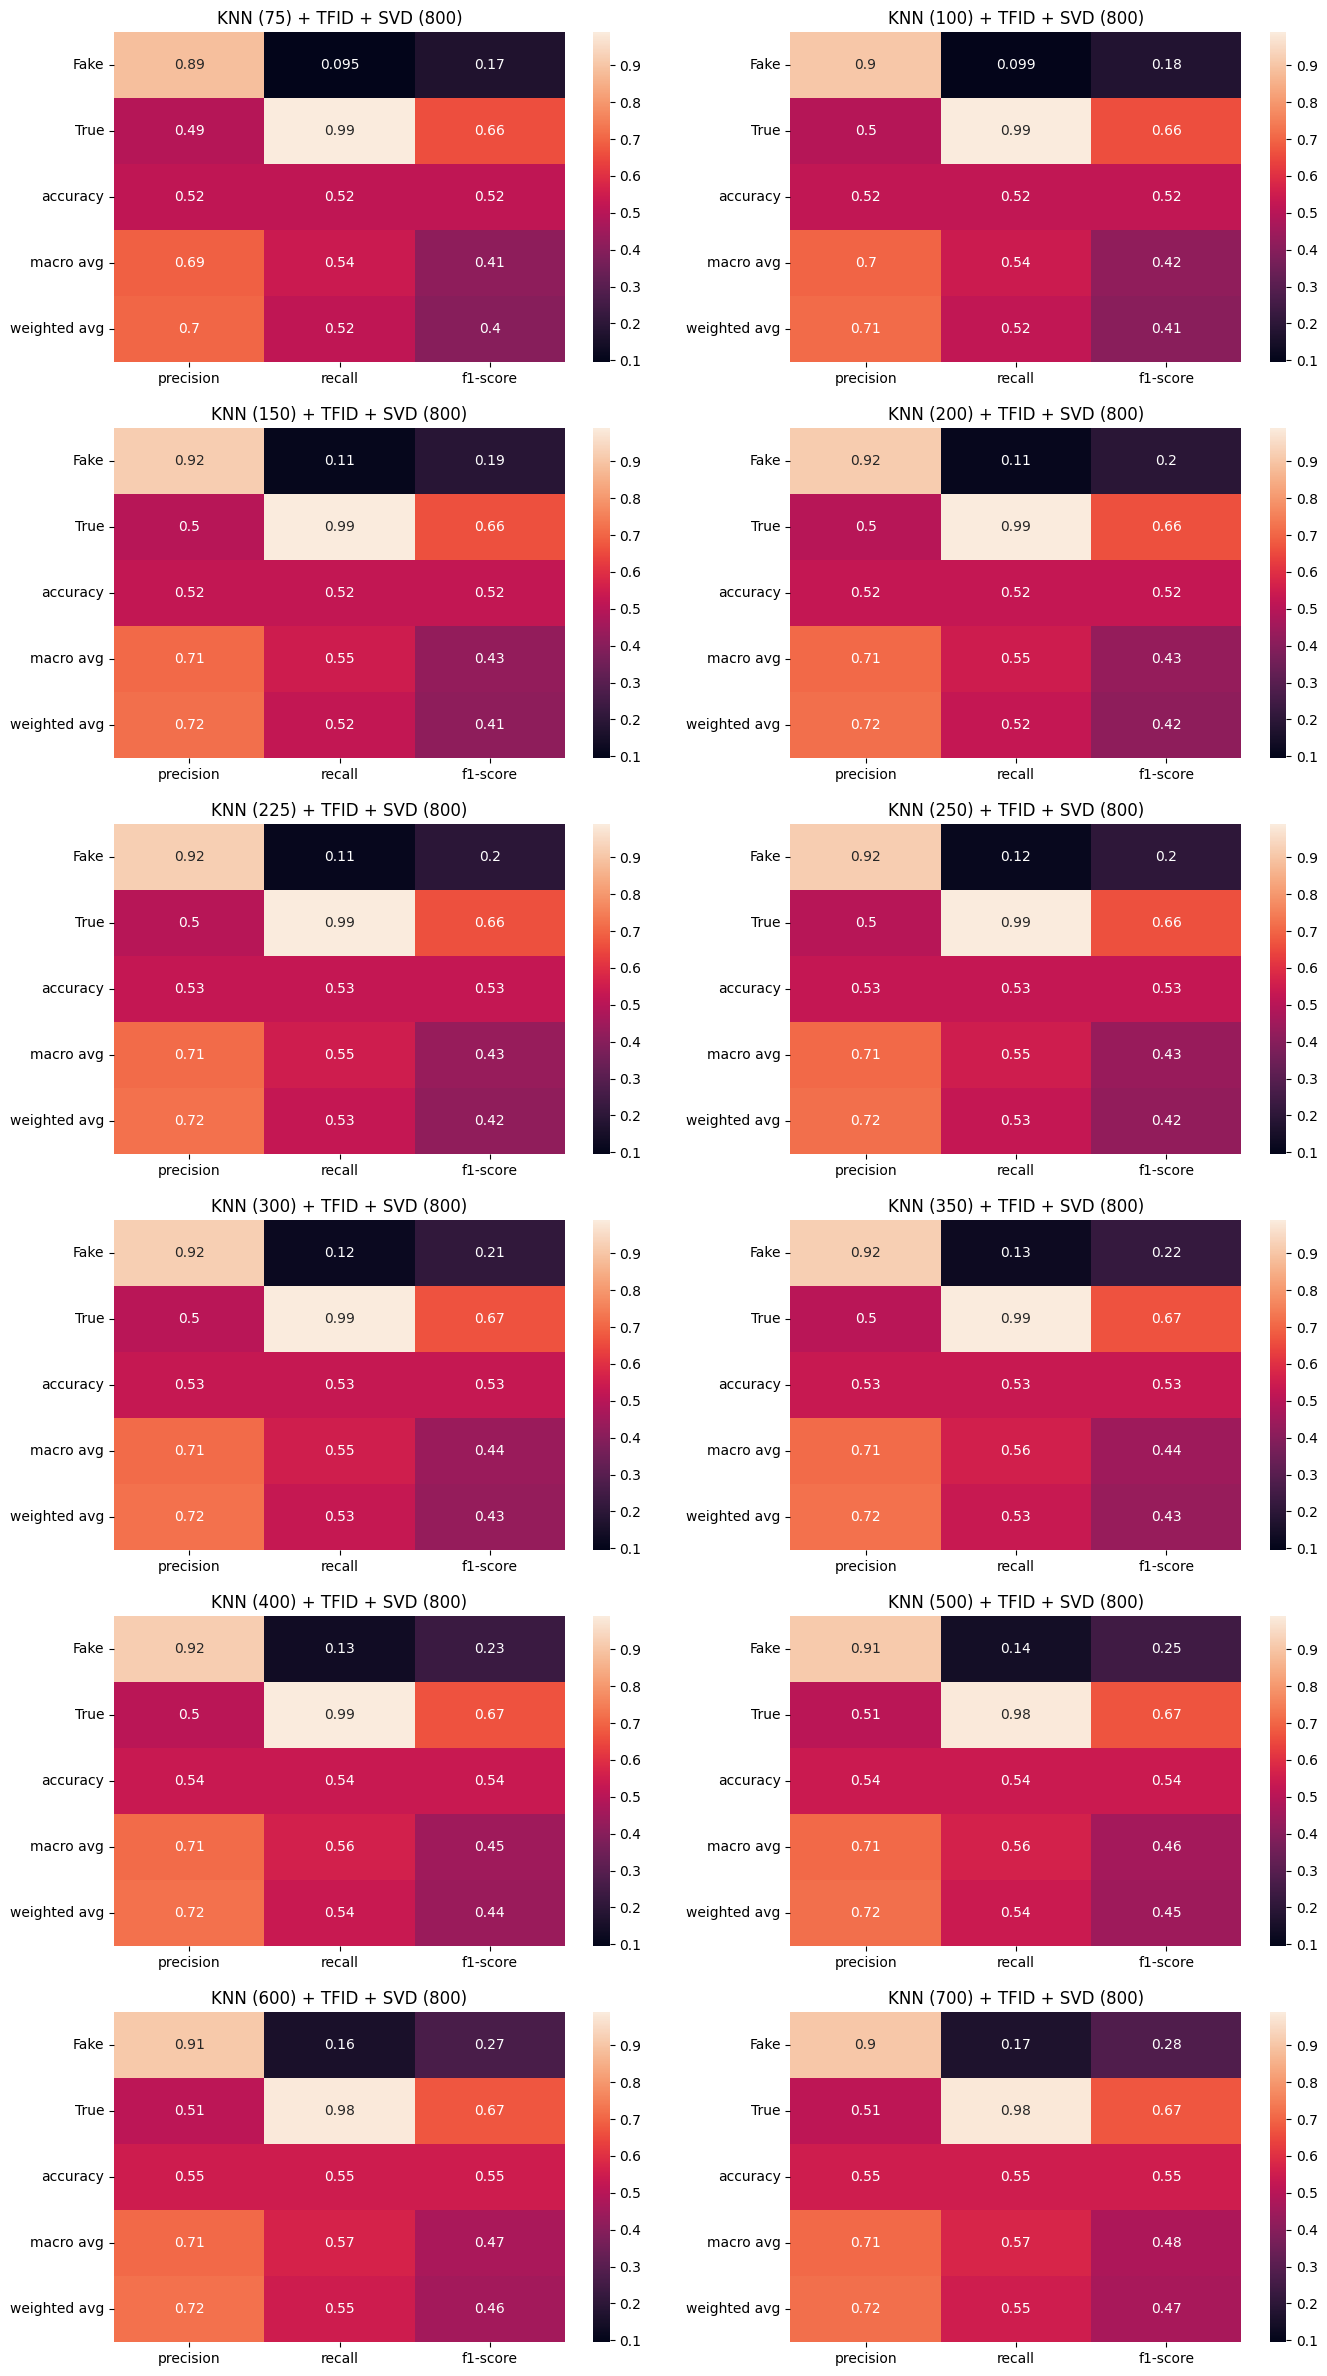

In [ ]:
report_fig, report_axes = plot_clasification_reports(
    trained_KNN_TDIF_models, labels, target_names
)

#### Ahora probamos con CountVectorizer


In [ ]:
KNN_COUNT_models = []
N_COMPONENTS = 800

for k in K_values:
    model = KNeighborsClassifier(n_neighbors=k, n_jobs=N_JOBS)
    model.fit(x_count_train_svd, y_train)
    KNN_COUNT_models.append(model)

In [ ]:
trained_KNN_COUNT_models = []
for model in KNN_TFID_models:
    trained_model = TrainedModel(model, f"KNN ({model.n_neighbors}) + COUNT + SVD ({N_COMPONENTS})", x_tfid_test_svd, y_test)
    trained_KNN_COUNT_models.append(trained_model)

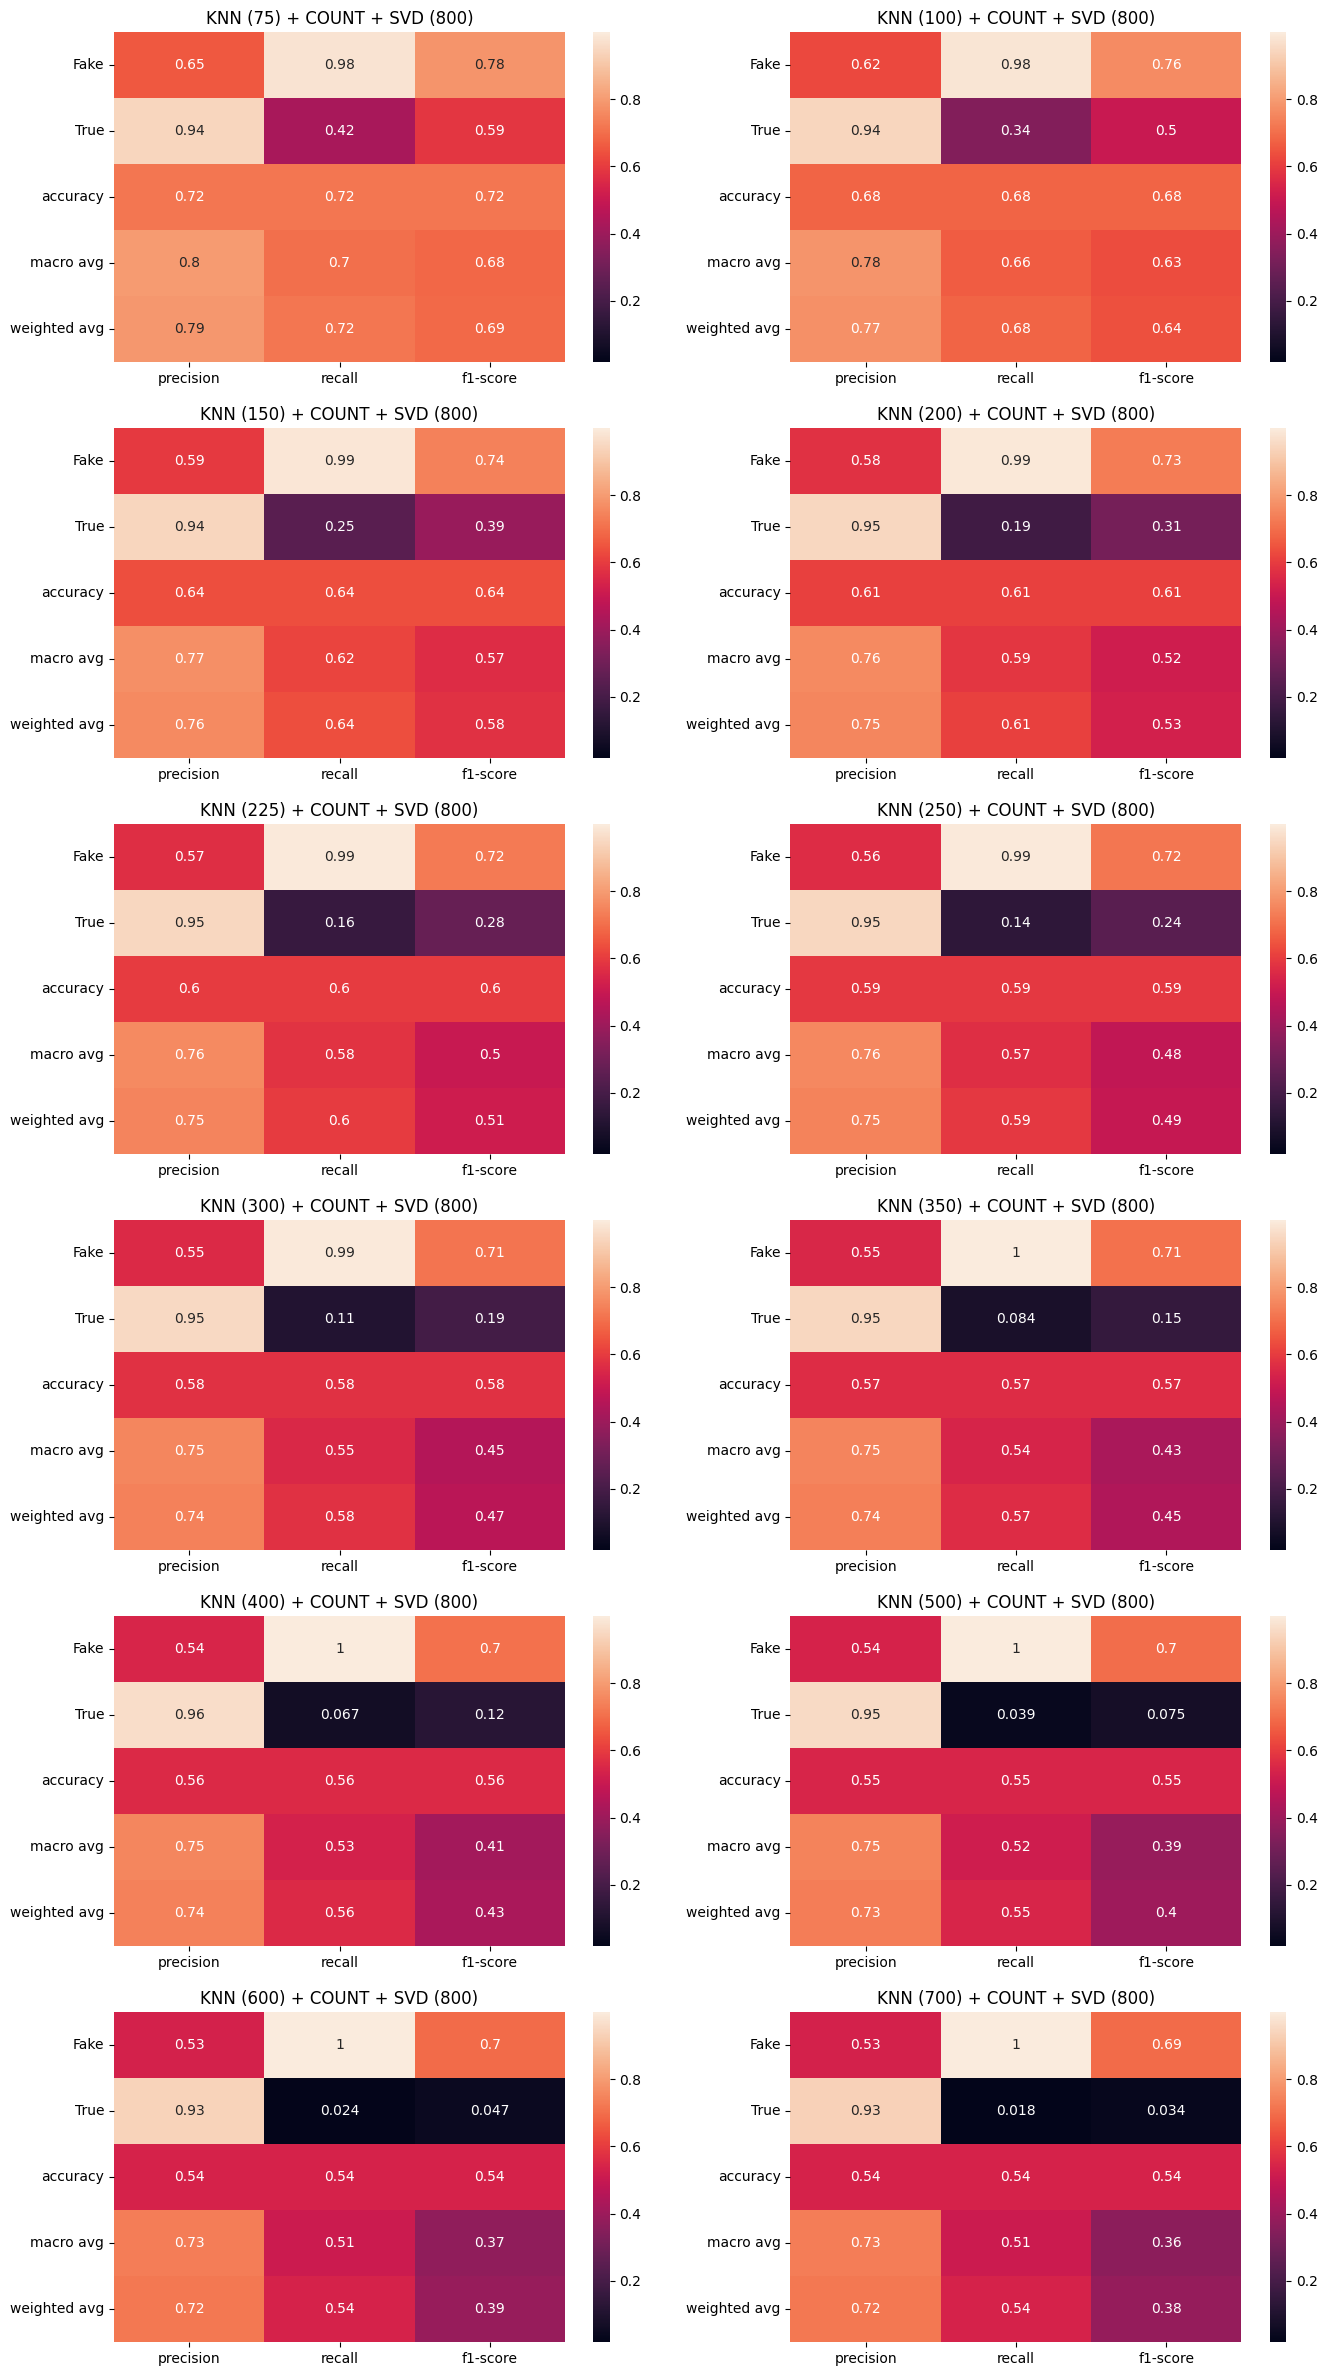

In [ ]:
report_fig, report_axes = plot_clasification_reports(
    trained_KNN_COUNT_models, labels, target_names
)

In [23]:
# Vectorización con Word2Vec
def words_W2V(x_train, x_test):
  # Concatenar series2 al frente de series1
  X = pd.concat([x_train, x_test], axis=0)
  sentences = [text.split() for text in X]
  word2vec_model = Word2Vec(sentences, min_count=1)
  
  return list(word2vec_model.wv.index_to_key)

In [24]:
words = words_W2V(x_train, x_test)

In [26]:
words[:100]

['trump',
 'said',
 'state',
 'president',
 'people',
 'year',
 'republican',
 'new',
 'government',
 'reuters',
 'clinton',
 'time',
 'house',
 'obama',
 'donald',
 'american',
 'country',
 'election',
 'right',
 'party',
 'united',
 'like',
 'told',
 'white',
 'campaign',
 'official',
 'news',
 'group',
 'law',
 'washington',
 'day',
 'week',
 'hillary',
 'vote',
 'security',
 'medium',
 'court',
 'national',
 'want',
 'political',
 'woman',
 'democrat',
 'police',
 'leader',
 'image',
 'million',
 'know',
 'way',
 'percent',
 'month',
 'administration',
 'twitter',
 'according',
 'support',
 'going',
 'think',
 'russia',
 'member',
 'america',
 'presidential',
 'statement',
 'tax',
 'democratic',
 'called',
 'policy',
 'office',
 'senate',
 'report',
 'attack',
 'including',
 'north',
 'world',
 'public',
 'department',
 'need',
 'russian',
 'military',
 'federal',
 'city',
 'come',
 'candidate',
 'foreign',
 'case',
 'thing',
 'work',
 'nation',
 'issue',
 'saying',
 'plan',
 'tues

In [47]:
def freq_W2V(data):
  # Concatenar series2 al frente de series1
  #X = pd.concat([x_train, x_test], axis=0)
  sentences = [text.split() for text in data]
  word2vec_model = Word2Vec(sentences, min_count=1)
  
  return list(word2vec_model.wv.index_to_key)

In [45]:
clean_fake = dataFake.copy()
lemmatizer = WordNetLemmatizer()
clean_fake['text'] = clean_fake['text'].apply(text_cleaner, args=(lemmatizer,))

In [46]:
clean_fake['text']

0        donald trump couldn wish american happy new ye...
1        house intelligence committee chairman devin nu...
2        friday revealed milwaukee sheriff david clarke...
3        christmas day donald trump announced work foll...
4        pope francis annual christmas day message rebu...
                               ...                        
23476    century wire say reported earlier week unlikel...
23477    century wire say familiar theme dispute change...
23478    patrick henningsen century wireremember obama ...
23479    century wire say jazeera america history bigge...
23480    century wire say predicted new year look ahead...
Name: text, Length: 23481, dtype: object

In [48]:
fake_words = freq_W2V(clean_fake['text'])

In [ ]:
fake_words[:100]

In [51]:
clean_true = dataTrue.copy()
lemmatizer = WordNetLemmatizer()
clean_true['text'] = clean_true['text'].apply(text_cleaner, args=(lemmatizer,))

In [52]:
true_words = freq_W2V(clean_true['text'])

In [ ]:
true_words[:100]

In [54]:
clean_true.text.str.split(expand=True).stack().value_counts()

said            99062
trump           54728
state           37672
reuters         28973
president       28726
                ...  
chorlton            1
treize              1
clipped             1
gambetta            1
perdangangan        1
Length: 56758, dtype: int64

In [55]:
clean_fake.text.str.split(expand=True).stack().value_counts()

trump         79318
said          33761
president     28270
people        26621
state         23622
              ...  
thumper           1
nazarene          1
pronovost         1
nomineee          1
mondoweiss        1
Length: 72657, dtype: int64

In [56]:
clean_true.text.str.split(expand=True).stack().value_counts().iloc[:15]

said          99062
trump         54728
state         37672
reuters       28973
president     28726
republican    23006
year          22622
government    19992
house         17029
new           16917
united        15586
people        15356
party         15294
election      14759
official      14620
dtype: int64

In [58]:
clean_fake.text.str.split(expand=True).stack().value_counts().iloc[:15]

trump         79318
said          33761
president     28270
people        26621
state         23622
clinton       19783
time          19174
year          19047
obama         18751
like          18637
american      18086
donald        17652
republican    16713
right         14843
news          14601
dtype: int64